# topic-model-v2
SanjayKAroraPhD@gmail.com <br>
December 2018

## Description
This notebook trains topic models on firm pages, segmenting those pages by firm groups as appropriate, and prepares topic modeling outputs at the paragraph level for subsequent Markov modeling.  v2 limits segments to small nano, renewable energy, and sybio firms and transitions to lda mallet (besides for perplexity scores, which don't seem too helpful anyways)

## TODO:

In [1]:
%matplotlib inline
import os
import os.path
import random
import re
import gensim
import string
import math
from gensim import corpora
from gensim import utils
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [3]:
# set this home data dir
BASE_DATA_DIR = "/Users/sarora/dev/EAGER/data/"
# for groups of words not in sentence format, group chunks of content; this is measured in number of characters 
MALLET_PATH = '/Users/sarora/dev/EAGER/libraries/mallet-2.0.8/bin/mallet' # update this path
PHRASE_LENGTH = 60
MIN_PARA_LEN = 5

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [4]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/parsed_page_output/' # where in files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [5]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(in_path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc.
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
        documents_dict[files[i]] = text #make a list of lists

## Data Prep

### Prepare text for topic modelling

In [6]:
# run once if needed and download the popular corpora (e.g., stopwords) 
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# pattern regex to remove unwanted words that show up in topic models
p = re.compile(r"(\(\)|''|``|\"|null|ul|li|ol|^\.|^:|^/|\\|--|cooki|'s|corpor|busi|inc\.|ltd|co\.|compan|keyboard|product|technolog)", flags=re.IGNORECASE)

def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += item.encode('ascii','ignore').decode('utf-8') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

#tokenize text for topic modelling
def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
    all_content_trimmed = [c for c in all_content_clnd if len(c) >= MIN_PARA_LEN ]
    
    all_content_no_dups = []
    seen = {}
    for trimmed in all_content_trimmed:
        trimmed_joined = '|'.join(trimmed)
        if trimmed_joined not in seen: 
            all_content_no_dups.append(trimmed)
            seen[trimmed_joined] = 1
        
    return all_content_no_dups

In [8]:
# test regex
return_for_model (['this is a technology corporation or company or business or firm that produces products and widgets using tech, research and productization', 
                   'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                   'a sentence with less than MIN_PARA_LEN',
                   'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                   'a sentence with less than MIN_PARA_LEN'])

[['firm', 'produc', 'widget', 'use', 'tech', 'research'],
 ['sentenc', '4', '42', 'text', 'quotat', 'comput', 'test', 'safeti', 'first']]

In [9]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print ("Working on " + str(len(dict_of_docs.keys())) + " firm documents")
    c = 1
    for key in dict_of_docs:
        
        document = dict_of_docs[key]
        # print ("Working on doc " + key)
        
        # loop over text and add title elements to the paragraph they describe
        joined = []
        buf = ''
        for i in range(len(document)): # figure out a way to chunk groups of content
            if re.search (r'cookie|privacy|terms|GDPR', document[i], re.IGNORECASE):
                continue
            if len(document[i]) <= 12 or len(document[i].split()) < MIN_PARA_LEN : # maybe a menu or simple pagragraph heading? 
                continue
            if re.search(r'(\.|;|\!)', document[i]): # found what appears to be a sentence
                if buf:
                    joined.append(buf.strip())
                    buf = ''
                joined.append(document[i].strip())
            elif len(buf) > PHRASE_LENGTH: # the rest of this code processes free-standing text 
                joined.append(buf.strip())
                buf = document[i]
            else: 
                buf = buf + ' ' + document[i]
        if buf:
            joined.append(buf.rstrip())
        
        # pp.pprint (joined)
        
        combined_text += joined # make a big list
        documents.append(joined) # make a list of lists
        # pp.pprint(return_for_model(joined))
        
        dict_of_processed_docs[key] = return_for_model(joined)
    
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    return train, test, dict_of_processed_docs

### Process Documents for Topic Modelling

In [10]:
# use the preceeding fuction to process the text data
pp = pprint.PrettyPrinter()
all_train, all_test, all_docs_dict = process_doc_list(documents_dict)
# pp.pprint(all_docs_dict)

Working on 924 firm documents


In [11]:
print (len(all_train))
print (len(all_test))
print (len(all_docs_dict.keys()))

20685
5171
924


[['would', 'express', 'gratitud', 'visit', 'websit'],
 ['manufactur', 'recharg', 'batteri', 'industri', 'automobil'],
 ['leader', 'energi', 'cutting-edg', 'materi', 'industri'],
 ['2007.10', 'mass-produc', 'world', 'first', 'amol'],
 ['05', 'particip', 'power', 'expo', '2016'],
 ['11', 'suppli', 'cylindr', 'batteri', 'china'],
 ['04', 'particip', 'auto', 'shanghai', '2015'],
 ['08', 'acquir', 'merg', 'ace', 'digitech'],
 ['02', 'establish', 'batteri', 'branch', 'vietnam'],
 ['08', 'mobil', 'display', 'set', 'sail'],
 ['03', 'rank', 'no.1', 'evalu', 'japan'],
 ['10', 'mass-produc', 'world', 'first', 'amol'],
 ['05', 'develop', 'world', 'largest', '17inch'],
 ['creativ', 'leader', 'market', 'foundat', 'forefront', 'effort'],
 ['use', 'produc', 'semiconductor', 'display', 'solar', 'panel'],
 ['ask', 'continu', 'interest', 'support', 'endeavor', 'enrich'],
 ['super-larg', 'pdp', 'high-tech', 'crts', 'digit', 'display'],
 ['2012.9', 'acquir', 'full', 'sbl', 'share', 'bosch'],
 ['2004.1', 'd

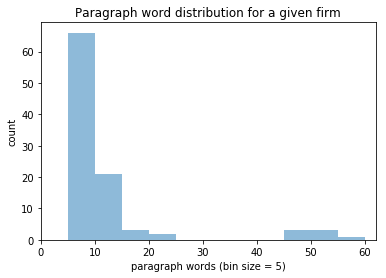

In [12]:
pp = pprint.PrettyPrinter()
# pp.pprint (documents_dict['22nd Century Limited.txt'])
# pp.pprint (all_docs_dict['22nd Century Limited.txt'])

test_firm_texts = [i for i in all_docs_dict['Samsung SDI Co.txt']]
lens = [len(t) for t in test_firm_texts]
pp.pprint (sorted(test_firm_texts, key=len))

bins = np.arange(0, 100, 5) # fixed bin size

plt.xlim([min(lens)-5, max(lens)+5])
plt.hist(lens, bins=bins, alpha=0.5)
plt.title('Paragraph word distribution for a given firm')
plt.xlabel('paragraph words (bin size = 5)')
plt.ylabel('count')

plt.show() # this exercise suggests removing all entries <6 words would make sense

In [52]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"

# standard firm cleaning regex
def clean_firm_name (firm):
    firm_clnd = re.sub('(\.|,| corporation| incorporated| llc| inc| international| gmbh| ltd)', '', firm, flags=re.IGNORECASE).rstrip()
    return firm_clnd

def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = list(map (lambda x: clean_firm_name(re.sub(r'\/', r'\|', x).rstrip('\r\n')) + '.txt', firms))
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print ("Cannot find " + name)
    return segment_dict

In [53]:
# create different training sets by industry
green_firms_file = "green_small_firms.csv"
synbio_firms_file = "synbio_small_firms.csv"
nano_firms_file = "nano_small_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_train, green_test, green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_train, nano_test, nano_docs = process_doc_list(nano_docs_dict)

Working on 173 firm documents
Working on 82 firm documents
Working on 185 firm documents


In [54]:
# train on all docs or a subset
all_train_test = all_train + all_test
synbio_train_test = synbio_train + synbio_test
nano_train_test = nano_train + nano_test 
green_train_test = green_train + green_test

## Run Topic Modelling

In [16]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [17]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] # possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

In [ ]:
all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)

In [ ]:
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

### Perplexity Plots for each website type

In [ ]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

In [ ]:
plt.plot(k, green_perplexities)

In [ ]:
plt.plot(k, synbio_perplexities)

In [ ]:
plt.plot(k, nano_perplexities)

### Compute coherence scores

In [55]:
# set k boundaries
limit=14; start=2; step=2

# Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (#17).
def compute_coherence_values(dictionary, corpus, texts,  start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus, id2word=dictionary, num_topics=num_topics, optimize_interval=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def visualize_coherence_values (train_test):
    full_dict = corpora.Dictionary(train_test)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train_test]
    
    # Can take a long time to run
    model_list, coherence_values = compute_coherence_values(dictionary=full_dict, corpus=DT_matrix, texts=train_test, start=start, limit=limit,step=step)
    
    # Show graph
    x = list(range(start, limit, step))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Working on dataset: green


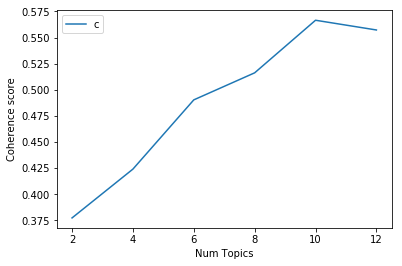

In [93]:
sector = 'green'

datasets = { 'green': {'train_test': green_train_test,'docs': green_docs_dict},
            'nano': {'train_test': nano_train_test, 'docs': nano_docs_dict}, 
            'synbio': {'train_test': synbio_train_test, 'docs': synbio_docs_dict }}

for key, data in datasets.items():
    if key != sector:
        continue
    print ('Working on dataset: ' + key)
    visualize_coherence_values(data['train_test'])

### Predict topics by paragraph

In [94]:
# define data structs and train model
dataset = datasets[sector]['train_test']
k = 6

full_dict = corpora.Dictionary(dataset)
DT_matrix = [full_dict.doc2bow(doc) for doc in dataset]

lda_mallet = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus=DT_matrix, num_topics=k, id2word=full_dict, optimize_interval=10)

#### Visualize topics

In [67]:
lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet) # viz doesn't work with mallet
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, DT_matrix, full_dict)
pyLDAvis.display(LDAvis_prepared)

In [95]:
x=lda_mallet.show_topics(num_topics=k, num_words=20,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
#Below Code Prints Topics and Words
labels = []
for topic,words in topics_words:
    pp.pprint(str(topic)+ "::"+ str(words))
    labels.append('|'.join(words[0:5]))

("0::['develop', 'custom', 'solut', 'provid', 'servic', 'innov', 'industri', "
 "'market', 'work', 'research', 'world', 'valu', 'energi', 'manag', 'creat', "
 "'qualiti', 'team', 'support', 'offer', 'make']")
("1::['power', 'solar', 'energi', 'system', 'manufactur', 'develop', 'cell', "
 "'electr', 'design', 'materi', 'commerci', 'generat', 'cost', 'effici', "
 "'high', 'fuel', 'electron', 'industri', 'test', 'engin']")
("2::['establish', 'group', 'year', 'award', 'intern', 'inc.', 'offic', "
 "'facil', 'manufactur', '2018', 'servic', 'center', '2017', 'global', 'citi', "
 "'headquart', 'plant', 'oper', '2014', 'locat']")
("3::['channel', 'report', 'law', 'arab', 'ani', 'profil', 'includ', "
 "'personnel', 'control', 'show', 'news', 'annual', 'entertain', 'launch', "
 "'repres', 'burn', 'content', 'program', 'movi', 'polici']")
("4::['paper', 'imag', 'system', 'machin', 'process', 'juic', 'manufactur', "
 "'color', 'organ', 'includ', 'start', 'camera', 'field', 'ricoh', 'industri', "
 

In [103]:
# print topic labels for import into R (note these need to be copied into R every time you train a new topic model)
print ("Copy this into R:")
labels_out = 'c("start|state","' + '", "'.join(labels) + '")'

print (labels_out)
labels_file = BASE_DATA_DIR + '/orgs/para_topics_panel/' + sector + '_labels.txt' # where output files are stored
if os.path.isfile(labels_file):
    os.remove(labels_file)
    
with open(labels_file, 'a') as lf:
    lf.write(labels_out)

Copy this into R:
c("start|state","develop|custom|solut|provid|servic", "power|solar|energi|system|manufactur", "establish|group|year|award|intern", "channel|report|law|arab|ani", "paper|imag|system|machin|process", "univers|manag|engin|develop|energi")


#### Create output data structure and write to file

In [97]:
# test topic inference and top topic extract in lda mallet
para_topic_2 = 'power develop energy provide service market custom system'
para_topic_3 = 'manage universal director president board leadership phd doctor'

topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(utils.simple_preprocess(para_topic_3))]], reverse = True)
pp.pprint(topic_by_prob)

print(topic_by_prob[0][1])
print(topic_by_prob[0][0])

[(0.8764449429994664, 5),
 (0.05322823580011093, 0),
 (0.027847325486614442, 1),
 (0.024001954458144525, 2),
 (0.009748869806547501, 4),
 (0.008728671449116175, 3)]
5
0.8764449429994664


In [98]:
topic_by_firm_vector = {} # at the firm level

# create output data structure
for firm_key in datasets[sector]['docs']: # or nano_docs or synbio_docs
    firm_paras = all_docs_dict[firm_key]
    print ('Working on ' + firm_key + ' with ' + str(len(firm_paras)) + ' paragraphs.')
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 0

    # start state
    main_topic.append(-1)
    main_topic_probs.append(1)
    para_order.append(order_num)
    order_num += 1
    para_len.append(0)
    
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(para)]], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num += 1

    firm_df = pd.DataFrame(
        {'firm': re.sub('\|', '/', firm_key.split('.')[0]), 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

Working on Senga Advisors.txt with 17 paragraphs.
Working on CyboEnergy.txt with 7 paragraphs.
Working on EMD Technologies.txt with 15 paragraphs.
Working on Ferro.txt with 4 paragraphs.
Working on FULL CIRCLE BIOCHAR.txt with 3 paragraphs.
Working on Glucan Biorenewables.txt with 1 paragraphs.
Working on GOAL ZERO.txt with 57 paragraphs.
Working on King Electric Vehicles.txt with 15 paragraphs.
Working on Iogen.txt with 6 paragraphs.
Working on Magnolia Solar.txt with 42 paragraphs.
Working on Newdoll Enterprises.txt with 8 paragraphs.
Working on US NUTRACEUTICALS.txt with 41 paragraphs.
Working on Sinton Consulting.txt with 11 paragraphs.
Working on SOL-ELECTRICA.txt with 4 paragraphs.
Working on Starsource Scientific.txt with 13 paragraphs.
Working on Sun Synchrony.txt with 2 paragraphs.
Working on Integrated Solar Technology.txt with 16 paragraphs.
Working on Wave Energy Conversion of America.txt with 11 paragraphs.
Working on Terra Caloric.txt with 11 paragraphs.
Working on Crysta

Working on SAE Magnetics (HK).txt with 3 paragraphs.
Working on Nippon Chemi-Con.txt with 6 paragraphs.
Working on Nanoco Technologies.txt with 67 paragraphs.
Working on ASCENT SOLAR TECHNOLOGIES.txt with 7 paragraphs.
Working on SolarReserve Technology.txt with 11 paragraphs.
Working on SolarCity.txt with 6 paragraphs.
Working on American Piledriving Equipment.txt with 23 paragraphs.
Working on SB ENERGY.txt with 11 paragraphs.
Working on Daikin Industries.txt with 70 paragraphs.
Working on SunLink.txt with 4 paragraphs.
Working on BTU.txt with 63 paragraphs.


In [99]:
# Test output for a given firm 
print ('Found output for ' + str(len(topic_by_firm_vector.keys())) + ' firms.  Here is an example:')
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['US NUTRACEUTICALS.txt'])
pp.pprint (all_docs_dict['US NUTRACEUTICALS.txt'])
print(topic_by_firm_vector['US NUTRACEUTICALS.txt'])

Found output for 173 firms.  Here is an example:
['COLLECTIONS:',
 'Home',
 'Author Spotlight',
 'Company',
 'Ethics',
 'History',
 'Vision',
 'Executive Team',
 'Directors',
 'Employees',
 'Current Open Positions',
 'Nutraceutical Benefits',
 'Catalog',
 'Brand Brochures',
 'Collections',
 'Healthy',
 'KAL',
 '®',
 '– Vitamin C',
 '– Clinical Lifestyle',
 'Innovation',
 'Solaray',
 '®',
 'Fermented Fungi',
 'Natural Woman',
 'Food Source®',
 'Sunny Green',
 '®',
 'Brand Brochure',
 'VegLife',
 '®',
 'Brand Brochure',
 'Beautiful',
 'Aubrey Organics',
 'Emerita',
 '®',
 'Heritage Store',
 'Emu Gold',
 '®',
 'Your Crown & Glory™',
 'Larénim',
 '®',
 'Life-flo',
 '®',
 'Collective Wellbeing',
 'Mababa™',
 '5K1N™',
 'Living Clay',
 'Living Flower Essences™',
 'Mia Rose',
 '®',
 'Simplers Botanicals™',
 'Organix',
 '®',
 'South',
 'Tea Tree Remedies™',
 'Naked Organix',
 '®',
 'TheraNeem',
 '®',
 'XyliVita',
 '®',
 'Skin by Ann Webb',
 '®',
 'Sunfeather™',
 'Zola Naturals™',
 '®',
 'MoistS

 'bioAllers',
 '®',
 'Herbs for Kids',
 '®',
 'Homeopathy for Kids™',
 'NatraBio',
 '®',
 'NaturalCare',
 '®',
 'Nutra BioGenesis™',
 'Oakmont Labs',
 '®',
 'Pioneer',
 '®',
 'VÄXA',
 '®',
 'Zand',
 '®',
 'Nature’s Herbs',
 '®',
 'Active',
 'Natural Balance',
 '®',
 'Natural Sport',
 '®',
 'BuckPower™',
 'Healthy Market',
 'FunFresh Foods®',
 'Dowd & Rogers™',
 'Miztique™',
 'Paleo Planet™',
 'Refrigerator Fresh™',
 'Sweet Moose™',
 'Taste Waves™',
 'World Berries™',
 'The Real Food Trading Co.™',
 'Zylicious™',
 'Spring Drops™',
 'Beehive',
 'Honey Gardens™',
 'Montana Big Sky™',
 'Premier One',
 '®',
 'Nutra Book',
 'Woodland Publishing®',
 'Pet Store',
 'ActiPet',
 '®',
 'The Pet Crystal',
 'ews',
 'Notices',
 'Events',
 'New Products',
 'Press Releases',
 'Retailers',
 'Retailer Login',
 'New Account Application',
 'Nature’s Cures Application',
 'Chain Update Form',
 'Contact Us',
 'Search',
 'Company',
 'History',
 'Vision',
 'Overview',
 'Executive Team',
 'Directors',
 'Careers'

In [100]:
# Write to a single output topic file
out_file = BASE_DATA_DIR + '/orgs/para_topics_panel/' + sector + '_out_topics.csv' # where output files are stored
headers = list(topic_by_firm_vector[list(topic_by_firm_vector.keys())[0]])
if os.path.isfile(out_file):
    os.remove(out_file)
with open(out_file, 'a') as f:
    f.write(','.join(headers) + '\n')
    for firm_key in topic_by_firm_vector:
        df = topic_by_firm_vector[firm_key]
        df.to_csv(f, header=False, index=False)
        
# now go to R